# MNIST digit recognizer with pytorch and Kaggle

This notebook develops a convolutional neural network with pytorch to identify hand written digits.


In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim

import os
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

/home/max/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Fetching the data

Before starting, we must download the data from Kaggle.

We'll store it in a subdirectory; create a `data/` directory if it does not already exist.

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

Then, download the training and test data sets if they do not already exist locally, ensuring that they end up in the `data/` directory. The data are available here: https://www.kaggle.com/c/digit-recognizer/data 

## Munging the data

We need to load the data and produce ndarrays for the training data (divided into a training set and validation set), which can be converted to pytorch tensors, where the inputs are 4d, with dimensions corresponding to 1) sample size, 2) number of channels, 3) width, and 4) height. The labels will be 1 dimensional integer vectors which indicate whether a handwritten digit is a "0", "1", ..., or "9". 

Loading the training data set with pandas, which has one row per example, and the columns represent unrolled pixel intensities.

In [3]:
df = pd.read_csv("data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, extract numeric values which represent intensities (excluding column 0), compute the maximum value for use in normalization later, and jot down the total number of examples.

In [4]:
imgs = df.iloc[:, 1:].values # iloc: integer indexing, values: numpy ndarray
max_imgs = np.max(imgs)
mean_imgs = np.mean(imgs)
sd_imgs = np.std(imgs)
ntot = imgs.shape[0]         # number of rows

imgs = imgs / max_imgs

Split the data into a 60/40 training and validation set.

In [5]:
ntrain = np.floor(ntot * .6)
train_indices = np.random.randint(0, int(ntot), size = int(ntrain))

nvalid = ntot - ntrain
valid_indices = np.setdiff1d(list(range(0, ntot)), train_indices)

## Cubing the training data

We've got to un-unroll the data into a 4d numpy array and create our vector of labels, divided into training and validation sets.

In [6]:
# create a ntrain * 28 * 28 ndarray of training set
cube = np.ndarray(shape = (ntot, 1, 28, 28), dtype = "float")

In [7]:
for i in range(0, ntot):
    cube[i, 0, :, :] = imgs[i, :].reshape(28, 28)

(array([ 27182695.,    399808.,    359330.,    306344.,    312800.,
           363558.,    317852.,    362706.,    427725.,   2895182.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

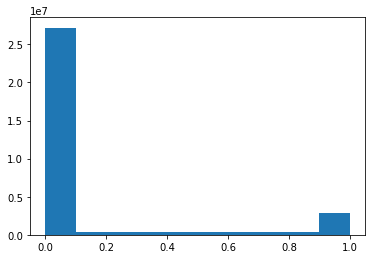

In [8]:
plt.hist(cube.flatten())

In [9]:
# Create a tensor containing the correct labels
labels = df.iloc[:, 0].values

In [10]:
# break data into training and validation sets
train_cube = torch.FloatTensor(cube[train_indices, :, :, :])
valid_cube = torch.FloatTensor(cube[valid_indices, :, :, :])

train_labels = torch.from_numpy(labels[train_indices])
valid_labels = torch.from_numpy(labels[valid_indices])

In [11]:
print(train_cube.size())
print(train_labels.size())
print(valid_cube.size())
print(valid_labels.size())

torch.Size([25200, 1, 28, 28])
torch.Size([25200])
torch.Size([23070, 1, 28, 28])
torch.Size([23070])


## Creating data loaders

We'll use pytorch's data utilities to create loaders for the training and test data.

In [30]:
trainset = torch.utils.data.TensorDataset(train_cube, train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 8, 
                                          shuffle = True, num_workers = 2)

testset = torch.utils.data.TensorDataset(valid_cube, valid_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size = 8, 
                                          shuffle = True, num_workers = 2)

## Visualize some training examples


    8     0     6     5     1     9     1     5


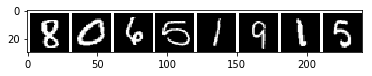

In [31]:
def imshow(img):
    img = img # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'%int(labels.numpy()[j]) for j in range(trainloader.batch_size)))

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv1_drop = nn.Dropout2d()
        self.conv2 = nn.Conv2d(20, 40, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(640, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net

Net (
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv1_drop): Dropout2d (p=0.5)
  (conv2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (640 -> 120)
  (fc1_drop): Dropout (p = 0.5)
  (fc2): Linear (120 -> 10)
)

In [33]:
params = list(net.parameters())
print(len(params))
print(params[0].size())
print(params[2].size())
print(params[4].size())

8
torch.Size([20, 1, 5, 5])
torch.Size([40, 20, 5, 5])
torch.Size([120, 640])


In [34]:
optimizer = optim.Adam(net.parameters())

In [35]:
def train(epoch):
    net.train()
    for batch_index, (inputs, labels) in enumerate(trainloader):
        inputs, labels = Variable(inputs), Variable(torch.squeeze(labels))
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        if batch_index % 400 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_index * len(inputs), len(trainloader.dataset),
                    100. * batch_index / len(trainloader), loss.data[0]))

In [36]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        data, target = Variable(data, volatile=True), Variable(torch.squeeze(target))
        output = net(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

In [37]:
for epoch in range(3): # loop over the dataset multiple times
    train(epoch)
    test(epoch)

Train Epoch: 0 [0/25200 (0%)]	Loss: 2.276732
Train Epoch: 0 [3200/25200 (13%)]	Loss: 0.929732
Train Epoch: 0 [6400/25200 (25%)]	Loss: 1.183684
Train Epoch: 0 [9600/25200 (38%)]	Loss: 0.338008
Train Epoch: 0 [12800/25200 (51%)]	Loss: 1.269049
Train Epoch: 0 [16000/25200 (63%)]	Loss: 1.211067
Train Epoch: 0 [19200/25200 (76%)]	Loss: 0.193084
Train Epoch: 0 [22400/25200 (89%)]	Loss: 1.228068

Test set: Average loss: 0.1349, Accuracy: 22137/23070 (96%)

Train Epoch: 1 [0/25200 (0%)]	Loss: 0.308205
Train Epoch: 1 [3200/25200 (13%)]	Loss: 0.129992
Train Epoch: 1 [6400/25200 (25%)]	Loss: 0.515302
Train Epoch: 1 [9600/25200 (38%)]	Loss: 0.029864
Train Epoch: 1 [12800/25200 (51%)]	Loss: 0.036533
Train Epoch: 1 [16000/25200 (63%)]	Loss: 0.447933
Train Epoch: 1 [19200/25200 (76%)]	Loss: 0.178763
Train Epoch: 1 [22400/25200 (89%)]	Loss: 0.418185

Test set: Average loss: 0.0897, Accuracy: 22428/23070 (97%)

Train Epoch: 2 [0/25200 (0%)]	Loss: 0.777757
Train Epoch: 2 [3200/25200 (13%)]	Loss: 0.09399